In [1]:
import numpy as np
import pandas as pd
from pandas import datetime
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams

In [2]:
def parser(x):
    return datetime.strptime(x,'%Y-%m')
data=pd.read_csv('potato_import.csv', index_col=0 ,parse_dates = [0], date_parser = parser)
mean_Quantity = data['Quantity'].median(skipna=True)
data.loc[data.Quantity == 0, 'Quantity'] = mean_Quantity
training_data = data[:round(len(data)*0.85)]
test_data = data[round(len(data)*0.85):]

/home/redeye/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  


In [3]:
len_training = len(training_data)

In [4]:
training_data_logscale = np.log(training_data)

In [5]:
movingavg = training_data_logscale.rolling(window=12).mean()
movingstd = training_data_logscale.rolling(window=12).std()
# plt.plot(training_data)
# plt.plot(movingavg, 'red')
# plt.plot(movingstd, 'green')

In [6]:
datasetlogscalemovingavg = training_data_logscale - movingavg
datasetlogscalemovingavg.dropna(inplace=True)

In [7]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    movingavg = timeseries.rolling(window=12).mean()
    movingstd = timeseries.rolling(window=12).std()
   

In [8]:
# test_stationarity(datasetlogscalemovingavg)

In [9]:
exp_decay_wt_avg = training_data_logscale.ewm(halflife=12, min_periods=0, adjust=True).mean()

In [10]:
data_logscale_minus_moving_exp_decay_avg = training_data_logscale - exp_decay_wt_avg

In [11]:
datasetlogdiffshifting = training_data_logscale - training_data_logscale.shift()

In [12]:
datasetlogdiffshifting.dropna(inplace=True)
# plt.xlabel("Date")
# plt.ylabel("Shifted log value")
# test_stationarity(datasetlogdiffshifting)

In [13]:
# from statsmodels.tsa.seasonal import seasonal_decompose
# decomposition = seasonal_decompose(training_data_logscale)

# trend = decomposition.trend
# seasonal = decomposition.seasonal
# residual = decomposition.resid

# plt.subplot(411)
# plt.plot(training_data_logscale, label='Original')
# plt.legend(loc='best')

# plt.subplot(412)
# plt.plot(trend, label='Trend')
# plt.legend(loc='best')

# plt.subplot(413)
# plt.plot(seasonal, label='Seasonal')
# plt.legend(loc='best')

# plt.subplot(414)
# plt.plot(residual, label='Residual')
# plt.legend(loc='best')

# plt.tight_layout()

# decompositionlogdata = residual
# decompositionlogdata.dropna(inplace=True)
# test_stationarity(decompositionlogdata)

In [14]:
# decompositionlogdata = residual
# decompositionlogdata.dropna(inplace=True)
# test_stationarity(decompositionlogdata)

In [15]:
# from statsmodels.tsa.stattools import acf, pacf

# lag_acf = acf(datasetlogdiffshifting,nlags=20)
# lag_pacf = pacf(datasetlogdiffshifting, nlags=20, method='ols')

# #plt.subplot(121)
# plt.axis([0, 8, -0.4, 1.0])
# plt.plot(lag_acf)
# plt.axhline(y=0,linestyle='--',color='gray')
# plt.axhline(y=-1.96/np.sqrt(len(datasetlogdiffshifting)),linestyle='--',color='gray')
# plt.axhline(y=1.96/np.sqrt(len(datasetlogdiffshifting)),linestyle='--',color='gray')
# plt.title('Autocorrelation function')



In [16]:
# #plt.subplot(122)
# plt.axis([0, 8, -0.4, 1.0])
# plt.plot(lag_pacf)
# plt.axhline(y=0,linestyle='--',color='gray')
# plt.axhline(y=-1.96/np.sqrt(len(datasetlogdiffshifting)),linestyle='--',color='gray')
# plt.axhline(y=1.96/np.sqrt(len(datasetlogdiffshifting)),linestyle='--',color='gray')
# plt.title('Partial Autocorrelation function')
# plt.tight_layout()

In [17]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(training_data_logscale,order=(21,1,1))
results_ar = model.fit(disp=-1)
rss = np.log(sum((results_ar.fittedvalues-datasetlogdiffshifting["Quantity"])**2))
print('RSS: %.4f'% rss)

/home/redeye/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/redeye/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


RSS: 2.4192


In [18]:
predic_arima_diff = pd.Series(results_ar.fittedvalues, copy=False)
# print(predic_arima_diff.head())

In [19]:
predic_arima_diff_cumsum = predic_arima_diff.cumsum()
# print(predic_arima_diff_cumsum.head())

In [20]:
predic_arima_log = pd.Series(training_data_logscale['Quantity'],index=training_data_logscale.index)
predic_arima_log = predic_arima_log.add(predic_arima_diff_cumsum, fill_value=0)
# predic_arima=np.exp(predic_arima_log)
# predic_arima

In [21]:
# predic_arima = np.exp(predic_arima_log)
# exp_log_indexdata = np.exp(training_data_logscale)
# plt.plot(exp_log_indexdata)
# plt.plot(predic_arima)

In [22]:
#indexdata_logscale
# exp_log_indexdata
# predic_arima

In [23]:
# np.exp(training_data_logscale)
# x =results_ar.plot_predict(1,180)
# x=results_ar.plot_predict(start=1, end=180, exog=None, dynamic=False, alpha=0.05, plot_insample=True, ax=None)
# print arma_order_select_ic(df.AverageTemperature, ic=['aic', 'bic'], trend='nc',
#             max_ar=4, max_ma=4, fit_kw={'method': 'css-mle'})

In [24]:
pred=results_ar.forecast(steps = 60)[0]
y = pred.tolist()
s = pd.Series(y, copy = False)
s=np.exp(s)

In [25]:
training_data=training_data.reset_index()

In [26]:
for x in range(len(s)):
    if(training_data.Month[len(training_data)-1].month < 12):
        m = training_data.Month[len(training_data)-1].month + 1
        y = training_data.Month[len(training_data)-1].year
    else:
        y = training_data.Month[len(training_data)-1].year + 1 
        m = 1
    d = '{}-{}'.format(y,m)
    d = datetime.strptime(d, '%Y-%m')
    training_data = training_data.append({'Month': d, 'Quantity': s[x]}, ignore_index=True)

/home/redeye/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  if __name__ == '__main__':


In [27]:
# training_data

In [28]:
training_data.set_index("Month", inplace = True)

In [29]:
original_data_plot = training_data[:len_training]

In [30]:
predicted_data = training_data[len_training:]

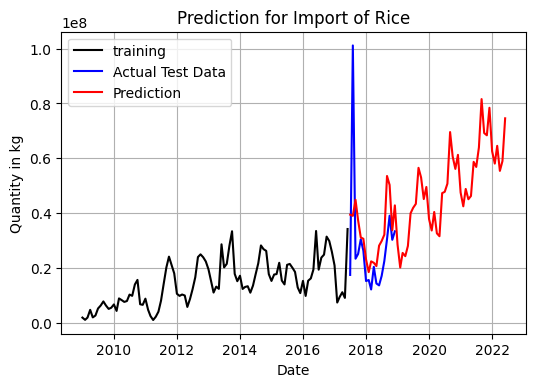

In [31]:
plt.figure(figsize=(6,4), dpi=100)
plt.title("Prediction for Import of Rice")
plt.xlabel("Date")
plt.ylabel("Quantity in kg")
plt.plot(original_data_plot,color = 'black', label='training')
plt.plot(test_data, color = 'blue', label='Actual Test Data')
plt.plot(predicted_data, color = 'red',label='Prediction')
plt.grid()
plt.legend(loc='best')